In [1]:
!pip install numpy matplotlib scikit-learn keras

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10

from skimage.feature import hog
from skimage import color
from skimage.transform import resize
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

2024-09-24 20:38:39.153341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 20:38:40.837161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


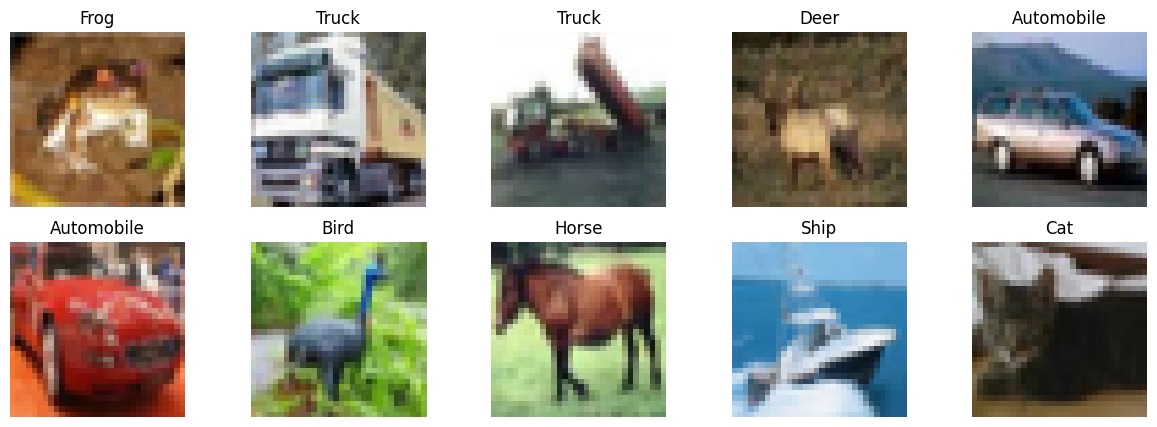

In [4]:
import matplotlib.pyplot as plt
from keras.datasets import cifar10

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# CIFAR-10 class labels
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Function to plot images
def plot_images(images, labels, class_names, num=10):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])
        plt.axis('off')
    plt.show()

# Display the first 10 images
plot_images(X_train, y_train, class_names)

In [5]:
# 加载 CIFAR-10 数据集
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 数据预处理：展平和归一化
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# 初始化 KNN 模型
knn = KNeighborsClassifier(n_neighbors=5)

# 训练模型
knn.fit(X_train, y_train.ravel())

# 进行预测
y_pred = knn.predict(X_test)

# 评估准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'KNN Accuracy: {accuracy * 100:.2f}%')

KNN Accuracy: 33.98%


In [39]:
# 加载 CIFAR-10 数据集
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 定义一个函数来提取 HOG 特征
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # 将彩色图像转换为灰度图像
        img_gray = color.rgb2gray(img)
        # 调整图像大小
        img_resized = resize(img_gray, (32, 32))
        # 提取 HOG 特征
        hog_feature = hog(img_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(hog_feature)
    return np.array(hog_features)

# 从训练和测试数据集中提取 HOG 特征
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# 初始化 KNN 模型
knn = KNeighborsClassifier(n_neighbors=5)

# 训练 KNN 模型
knn.fit(X_train_hog, y_train.ravel())

# 进行预测
y_pred = knn.predict(X_test_hog)

# 评估准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'KNN Accuracy with HOG features: {accuracy * 100:.2f}%')

KNN Accuracy with HOG features: 47.39%


In [6]:
# 加载 CIFAR-10 数据集
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 定义一个函数来提取 ORB 特征
def extract_orb_features(images, n_keypoints=500):
    orb = cv2.ORB_create(n_keypoints)
    orb_features = []
    for img in images:
        # 将彩色图像转换为灰度图像
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 检测 ORB 关键点和描述符
        keypoints, descriptors = orb.detectAndCompute(img_gray, None)
        if descriptors is not None:
            # 如果找不到描述符，填充为零数组
            orb_features.append(descriptors.flatten())
        else:
            orb_features.append(np.zeros(n_keypoints * 32))  # ORB 特征描述符长度为 32
    return np.array(orb_features)

# 从训练和测试数据集中提取 ORB 特征
X_train_orb = extract_orb_features(X_train)
X_test_orb = extract_orb_features(X_test)

# 初始化 KNN 模型
knn = KNeighborsClassifier(n_neighbors=5)

# 训练 KNN 模型
knn.fit(X_train_orb, y_train.ravel())

# 进行预测
y_pred = knn.predict(X_test_orb)

# 评估准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'KNN Accuracy with ORB features: {accuracy * 100:.2f}%')

KNN Accuracy with ORB features: 10.00%


In [7]:
# 加载 CIFAR-10 数据集
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 定义一个函数来提取 SIFT 特征
def extract_sift_features(images, n_keypoints=100):
    sift = cv2.SIFT_create()  # 创建 SIFT 对象
    sift_features = []
    
    for img in images:
        # 将彩色图像转换为灰度图像
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 检测 SIFT 关键点和描述符
        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        
        if descriptors is not None:
            # 如果描述符的数量少于 n_keypoints，则补齐
            if descriptors.shape[0] < n_keypoints:
                descriptors = np.pad(descriptors, ((0, n_keypoints - descriptors.shape[0]), (0, 0)), 'constant')
            # 如果描述符数量大于 n_keypoints，则截断
            descriptors = descriptors[:n_keypoints].flatten()
        else:
            # 如果没有找到描述符，填充为零数组
            descriptors = np.zeros((n_keypoints * 128))
        
        sift_features.append(descriptors)
    
    return np.array(sift_features)

# 从训练和测试数据集中提取 SIFT 特征
X_train_sift = extract_sift_features(X_train)
X_test_sift = extract_sift_features(X_test)

# 初始化 KNN 模型
knn = KNeighborsClassifier(n_neighbors=5)

# 训练 KNN 模型
knn.fit(X_train_sift, y_train.ravel())

# 进行预测
y_pred = knn.predict(X_test_sift)

# 评估准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'KNN Accuracy with SIFT features: {accuracy * 100:.2f}%')

KNN Accuracy with SIFT features: 20.78%


In [8]:
# 加载 CIFAR-10 数据集
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 使用 VGG16 预训练模型进行特征提取，去掉最后的全连接层 (include_top=False)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 预处理数据
X_train_preprocessed = preprocess_input(X_train)
X_test_preprocessed = preprocess_input(X_test)

# 使用 VGG16 提取特征
X_train_vgg_features = vgg_model.predict(X_train_preprocessed)
X_test_vgg_features = vgg_model.predict(X_test_preprocessed)

# 展平 VGG16 提取的特征
X_train_vgg_features_flattened = X_train_vgg_features.reshape(X_train_vgg_features.shape[0], -1)
X_test_vgg_features_flattened = X_test_vgg_features.reshape(X_test_vgg_features.shape[0], -1)

# 使用 KNN 进行分类
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_vgg_features_flattened, y_train.ravel())

# 进行预测
y_pred = knn.predict(X_test_vgg_features_flattened)

# 评估准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'KNN Accuracy with VGG16 features: {accuracy * 100:.2f}%')

2024-09-24 20:43:28.037894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 20:43:28.152932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 20:43:28.153405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

313/313 [==============================] - 2s 5ms/step
KNN Accuracy with VGG16 features: 58.69%
